## Boosted stumps 

In [2]:
import pandas as pd 
import numpy as np

from scipy.optimize import minimize 

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate 
import statistics
import csv 

%matplotlib inline
%store -r folds_performance
%store -r model_reliance
%store -r feat_weights
%store -r numwords2int

%store -r feat_weights_psa

In [3]:
data_path = "../data"
train_pd = pd.read_csv(data_path + "/train_stumps.csv")
test_pd = pd.read_csv(data_path + "/test_stumps.csv")
train_pd[train_pd == 0] = -1
test_pd[test_pd == 0] = -1

Y_train, Y_test = train_pd['recid_use'], test_pd['recid_use']
X_train, X_test = train_pd.copy(), test_pd.copy()
del X_train['recid_use']
del X_test['recid_use']
 
#all features 
Y_train, Y_test = np.array(Y_train), np.array(Y_test)
X_train, X_test = np.array(X_train), np.array(X_test)
nj
print(X_train.shape)

(1563, 411)


*Note*: 
The chunk below selects features which correspond to those used in the Arnold Foundation's PSA. The goal of this analysis was to discover whether using the boosted stumps with Adaboost approach would be more successful than the current model used by the Arnold Foundation (the PSA). We found that it was approximately equally successful.  Train accuracy is  0.6410748560460653, test accuracy is  0.6300268096514745.

In [ ]:
#select features used in the PSA
col_labels = np.array((train_pd.loc[:, train_pd.columns != 'recid_use']).columns.tolist())
unique_labels = np.unique(["_".join(label.split("_")[:-1]) for label in col_labels])
psa_features = ["p_current_age", "current_violent", "current_violent20", 
                "pending_charge", "prior_conviction_M", "prior_conviction_F", 
                "violent_conviction", "fail_appear_two_yr", "fail_appear_two_plus", 
                "p_prison"] #prior sentence to incarceration

psa_stumps = []
for label in col_labels: 
    no_num_label = "_".join(label.split("_")[:-1])
    if(no_num_label in psa_features): psa_stumps.append(label)

X_train_psa = np.array(train_pd.copy()[psa_stumps])
X_test_psa = np.array(test_pd.copy()[psa_stumps])

In [9]:
def AdaBoost_train(X, Y, T):
    '''
    @param X: n x p np array
    @param Y: labels for X, y \in {-1,1}
    @param T: number iterations
    returns: a p x 1 vector of weights on each feature
    '''
    # d_t should be n x 1 vector
    # alpha should be T x 1 vector (weight for each weak classifier)
    n, p = X.shape[0], X.shape[1]
    d = np.ones(n)* (1/n)
    
    def featureClassifier(X, Y, n, p, d):
        '''
        All features above are binary
        Returns the index of the feature which performs best as a classifier
        '''
        weighted_error  = np.ones(p)
        all_misclass = []
        for j in range(p):
            #compute misclassification error
            misclass = np.array([1 if Y[i]!= X[i,j] else 0 for i in range(n)]) #ones vector s.t. label col != feature j
            #record weighted error for jth feature
            weighted_error[j] = np.dot(misclass, d)
            all_misclass.append(misclass)
        #pick the jth feature which minimizes the weighted misclassification error
        best_j, error_j = np.argmin(weighted_error), np.min(weighted_error)
        return best_j, error_j, all_misclass[best_j]
     
    alphas, classifier_inds = np.zeros(T), np.zeros(T)

    for t in range(T):
        if t%200 == 0: print("t = ", t)
        best_j, epsilon, misclass = featureClassifier(X,Y,n,p,d)
        #compute weights on weak classifiers 
        alpha = .5 * np.log((1-epsilon)/epsilon)
        alphas[t] = alpha
        classifier_inds[t] = best_j
        
        #update weights on points
        misclass_inds, correct_inds = np.argwhere(misclass == 1), np.argwhere(misclass == 0)
        d[misclass_inds] *= np.exp(alpha) 
        d[correct_inds] *= np.exp(-alpha) 
#         perform normalization
        Z = np.sum(d)
        d = d/Z
    #compute weights on each feature from alphas 
    
    feat_weights = np.zeros(p)
    for i,classifier_ind in enumerate(classifier_inds): 
        feat_weights[int(classifier_ind)] += alphas[i]
    return feat_weights 

T = 1000
# feat_weights = AdaBoost_train(X_train,Y_train, T)
%store feat_weights

Stored 'feat_weights' (ndarray)


In [11]:
def AdaBoost_predict(X, feat_weights, threshold = .5):
    '''
    Converts AdaBoost predictions to probabilities and outputs a class 
    @param X: np array of data to predict on 
    @param alphas: weights on each feature 
    @param classifier_inds: indices of the features we use as weak classifiers
    '''
    raw = X @ feat_weights
    probas = np.exp(2*raw) / (1 + np.exp(2*raw))
    #threshold probabilities to get a class
    preds = np.copy(probas)
    preds[probas > threshold] = 1
    preds[probas <= threshold] = -1
    return probas, preds 
    
def AdaBoost_accuracy(X_train, Y_train, X_test, Y_test, feat_weights, threshold = .5):
    '''Computes training and test accuracy using weak classifiers from AdaBoost_train. '''
    
    train_probas,train_preds = AdaBoost_predict(X_train, feat_weights, threshold)
    test_probas, test_preds = AdaBoost_predict(X_test, feat_weights, threshold)
    #percent correctly classified
    train_acc =  sum([1 for i in range(len(Y_train)) if train_preds[i] == Y_train[i] ])/len(Y_train) 
    test_acc =  sum([1 for i in range(len(Y_test)) if test_preds[i] == Y_test[i] ])/len(Y_test)
    return train_acc, test_acc

def AdaBoost_auc(X_train, Y_train, X_test, Y_test, feat_weights):
    ''' Computes training and test aucs  '''
    
    train_probas, _ = AdaBoost_predict(X_train, feat_weights)
    train_fpr, train_tpr, _ = roc_curve(Y_train, train_probas) #compute fpr, tpr, auc
    train_auc = auc(train_fpr, train_tpr)

    test_probas, _ = AdaBoost_predict(X_test, feat_weights)
    test_fpr, test_tpr, _ = roc_curve(Y_test, test_probas) #compute fpr, tpr, auc
    test_auc = auc(test_fpr, test_tpr)
    
    return train_auc, train_fpr, train_tpr, test_auc, test_fpr, test_tpr 

#######################
train_acc, test_acc = AdaBoost_accuracy(X_train, Y_train, X_test, Y_test, feat_weights)
train_auc, _, _, test_auc, _, _ = AdaBoost_auc(X_train, Y_train, X_test, Y_test, feat_weights)

print("Train accuracy is ", train_acc, "\nTest accuracy is ", test_acc)
print("Train auc is ", train_auc, "\nTest auc is ", test_auc)

Train accuracy is  0.6436340371081254 
Test accuracy is  0.6702412868632708
Train auc is  0.692854387370545 
Test auc is  0.6881929046563193


# Cross validation code 

In [14]:
cv = KFold(n_splits = 4,random_state = 4924, shuffle = True)
T = 500

folds_performance = []
fold_ind = 0

#run c.v. on the training set, use the test set as a final test set 
#this is done in order to gather evaluation metrics in a consistent way with 
#how we evaluated other models

for train_inds, test_inds in cv.split(X_train,Y_train): 
    print("Fold ", fold_ind)
    fold_ind+=1
    X_train_fold, Y_train_fold = X_train[train_inds], Y_train[train_inds]
    X_test_fold, Y_test_fold = X_train[test_inds], Y_train[test_inds]
    
    #train AdaBoost
    feat_weights = AdaBoost_train(X_train_fold,Y_train_fold, T)
    Ada_train_auc, Ada_train_fpr, Ada_train_tpr, Ada_test_auc, Ada_test_fpr, Ada_test_tpr = AdaBoost_auc(X_train_fold, Y_train_fold, X_test_fold, Y_test_fold, feat_weights)

    #compute accuracies on train and test for AdaBoost
    Ada_train_acc, Ada_test_acc = AdaBoost_accuracy(X_train_fold, Y_train_fold, X_test_fold, Y_test_fold, feat_weights)
 
    folds_performance.append({
        #AdaBoost performance
        "ada_train_fpr" : Ada_train_fpr, 
        "ada_train_tpr": Ada_train_tpr, 
        "ada_train_auc": Ada_train_auc, 

        "ada_test_fpr" : Ada_test_fpr, 
        "ada_test_tpr": Ada_test_tpr, 
        "ada_test_auc": Ada_test_auc, 
        
        "ada_train_acc": Ada_train_acc, 
        "ada_test_acc": Ada_test_acc, 
        "ada_feat_weights": feat_weights 
    })

%store folds_performance

Fold  0
t =  0
t =  200
t =  400
Fold  1
t =  0
t =  200
t =  400
Fold  2
t =  0
t =  200
t =  400
Fold  3
t =  0
t =  200
t =  400
Stored 'folds_performance' (list)


In [21]:
Y_test.shape

(373,)

## ROC 

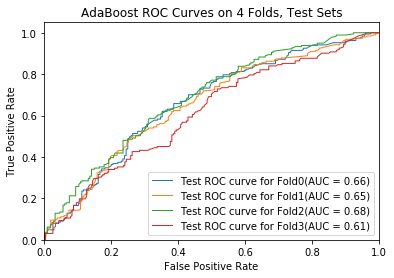

In [16]:
#Plot ROC curves for all folds, test sets 
for i, fold_info in enumerate(folds_performance): 
    plt.plot(fold_info["ada_test_fpr"], fold_info["ada_test_tpr"],
             label='Test ROC curve for Fold'+ str(i) + '(AUC = {0:0.2f})'.format(fold_info["ada_test_auc"]),
             linewidth=1)

plt.title('AdaBoost ROC Curves on 4 Folds, Test Sets')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='best')
plt.show()


## Accuracy, AUC

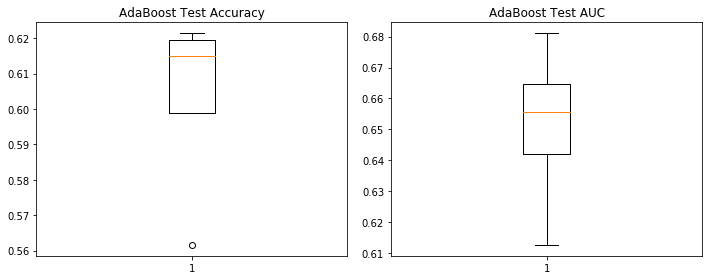

In [17]:
#Get mean and std dev for test acc, test AUC, train acc, train AUC
ada_testacc_list, ada_testauc_list = [], []
ada_trainacc_list, ada_trainauc_list = [], []

for fold_info in folds_performance:
    ada_testacc_list.append(fold_info["ada_test_acc"])
    ada_testauc_list.append(fold_info["ada_test_auc"])

    ada_trainacc_list.append(fold_info["ada_train_acc"])
    ada_trainauc_list.append(fold_info["ada_train_auc"])

#plot mean and std dev for test acc, test AUC
def boxplots(algorithm, test_acc, test_auc):
    #box plot using test accuracy 
    fig, (bp1_ax, bp2_ax) = plt.subplots(1,2, figsize=(10,4))
    bp1_ax.set_title(algorithm + " Test Accuracy")
    bp1_ax.boxplot(np.array(test_acc))

    #box plot using AUC
    bp2_ax.set_title(algorithm + " Test AUC")
    bp2_ax.boxplot(np.array(test_auc))

    plt.tight_layout()  
    plt.show()

boxplots("AdaBoost", ada_testacc_list, ada_testauc_list)

In [24]:
#log model results to the model performance folder, as per standards
res_path = "../logs/models/model_eval_metrics/"
test_auc_mean, test_auc_std = statistics.mean(ada_testauc_list), statistics.stdev(ada_testauc_list)
train_auc_mean, train_auc_std = statistics.mean(ada_trainauc_list), statistics.stdev(ada_trainauc_list)

heldout_test_auc = test_auc 
heldout_test_acc = test_acc

res = [["Score", "train_auc_mean", "train_auc_std", "test_auc_mean", "test_auc_std", "heldout_test_auc", "heldout_test_acc"],
    ["Adaboost", train_auc_mean, train_auc_std, test_auc_mean, test_auc_std,heldout_test_auc, heldout_test_acc ]]

with open( res_path + 'ada_performance.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(res)

## Model reliance

In [114]:
#Compute error of AdaBoost test set
ada_error = 1 - AdaBoost_accuracy(X_train, Y_train,X_test, Y_test, feat_weights)[1]

model_reliance = []
col_labels = train_pd.columns.tolist()[1:]
for j in range(X_test.shape[1]): #iterate over features
    ada_avg_perm_error = 0

    #perform 10 shuffles of feature j and average the error obtained
    for k in range(10): 
        X_test_perm = np.copy(X_test)
        np.random.shuffle(X_test_perm[:,j])
        ada_avg_perm_error += ( 1 -  AdaBoost_accuracy(X_train, Y_train, X_test_perm, Y_test, feat_weights)[1])
    
    model_reliance.append([col_labels[j], ada_error - ada_avg_perm_error/10])
    
%store model_reliance 
print(tabulate(model_reliance, headers=["Feature", "AdaBoost"], floatfmt=".8f"))

Stored 'model_reliance' (list)
Feature                          AdaBoost
----------------------------  -----------
recid_use                      0.00000000
p_current_age_eighteen        -0.00616622
p_age_first_offense_eighteen   0.00000000
p_current_age_nineteen         0.00000000
p_age_first_offense_nineteen   0.00000000
p_current_age_twenty           0.00000000
p_age_first_offense_twenty     0.00000000
p_current_age_twenty1          0.00053619
p_age_first_offense_twenty1    0.00000000
p_current_age_twenty2         -0.01474531
p_age_first_offense_twenty2    0.00000000
p_current_age_twenty3          0.00375335
p_age_first_offense_twenty3    0.00000000
p_current_age_twenty4          0.00000000
p_age_first_offense_twenty4    0.00000000
p_current_age_twenty6          0.00000000
p_age_first_offense_twenty6    0.00000000
p_current_age_twenty8         -0.02654155
p_age_first_offense_twenty8    0.00000000
p_current_age_thirty           0.00000000
p_age_first_offense_thirty    -0.00804290
p_c

## Scoring Plots

In [115]:
#unclear whether feat_weights for eatures I don't care about should be 0 or -1 
def AdaBoost_feature_contr(X, feat_weights, feat_inds):
    '''
    Returns summed contribution of the stumps for 1 feature set. Makes all 
    other feature weights 0 and only keep the ones we care about to predict 
    on X. Therefore if we take the feature contributions for all feature sets 
    and sum them, we have the score from Adaboost. 
    
    @param X: an artificial dataset
    @param feat_inds: a np array of the indices we care about 
    '''
    feat_weights_select = np.copy(feat_weights)
    not_inds = np.array([i for i in range(X.shape[1]) if i not in feat_inds])
    feat_weights_select[not_inds] = 0 
    return X @ feat_weights_select #put 0s in feat_weights for all but the feats we care about

def shape_plot(feat_name,  feat_inds,total_feats,feat_weights, col_labels, numwords2int):
    '''
    @param col_labels: string names of all features 
    @param feat_name: string name of the feature we are making a shape plot for 
    @param total_feats: total number of features in data
    @parm numwords2int: dictionary mapping the string names for numbers to integers
    @param feat_inds: indices corresponding to stumps for this feature 
    '''
    age_feat = feat_name == "p_current_age" or feat_name == "p_age_first_offense"
    
    if age_feat: 
        feat_min = 18
        feat_max = 65
        
    else: 
        feat_min = 0
        feat_max = 10
        

    #init artificial data
    X_artificial = np.ones((feat_max - feat_min , total_feats))* -1

    for feat_value in range(feat_min, feat_max): #value for this feature which this obs is supposed to mimic
        for feat_ind in feat_inds: #age inds is indices of columns corresponding to stumps for this feature
            feat_name_number = col_labels[feat_ind] #string name of this age feature and the stump number
            #get the number ending of this feature 
            num_str = feat_name_number.split("_")[-1]
            num_int = numwords2int[num_str] #stump number in integer form 
            #feat_value - feat_min because 0 indexing
            if age_feat:
                X_artificial[feat_value - feat_min, feat_ind] = 1 if feat_value <= num_int else -1
            else: 
                X_artificial[feat_value - feat_min, feat_ind] = 1 if feat_value >= num_int else -1

    #ALTERNATE ATTEMPT TO PLOT AGE 
    feat_probas, _ = AdaBoost_predict(X_artificial, feat_weights)
    feat_contr = AdaBoost_feature_contr(X_artificial, feat_weights, feat_inds)

    #computed by making all other feature weights 0
    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(feat_min, feat_max), feat_contr)
    plt.title('AdaBoost GAM Shape Curve: '+ feat_name )
    plt.xlabel( feat_name +' value')
    plt.ylabel('Contribution to Recidivism Score')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.show()
    plt.close()



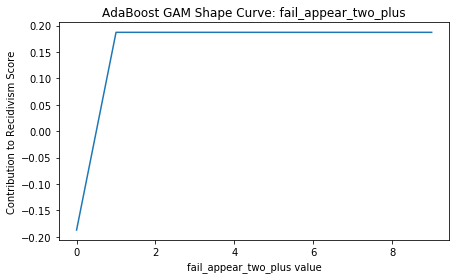

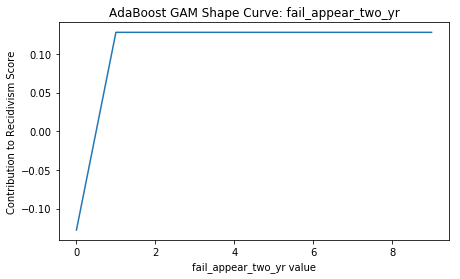

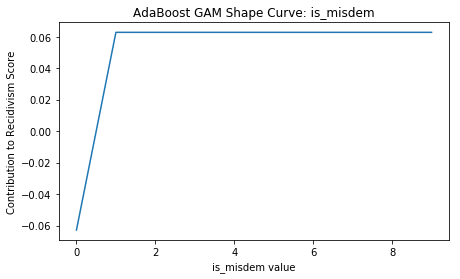

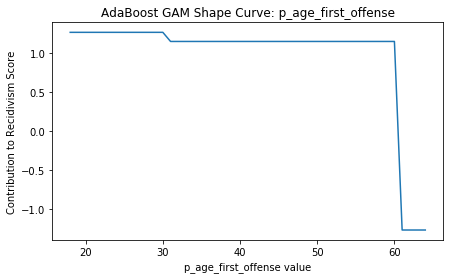

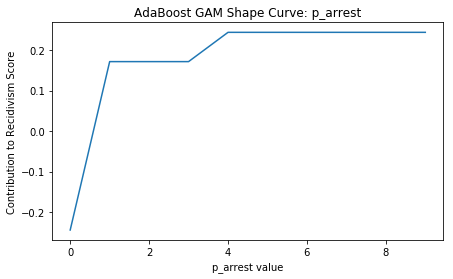

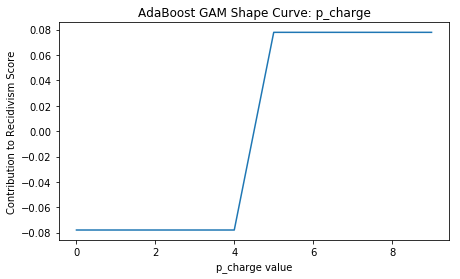

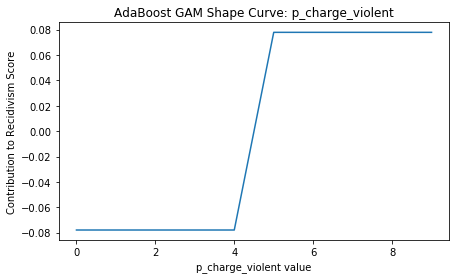

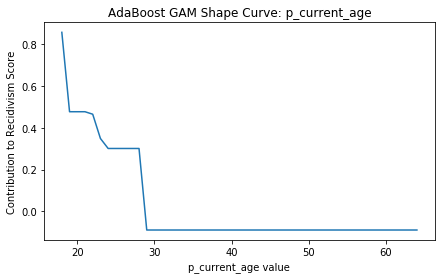

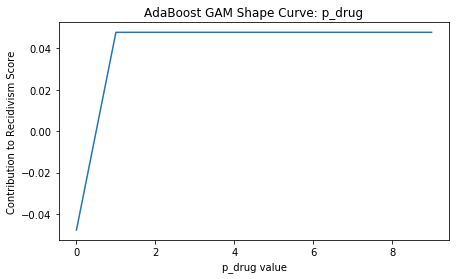

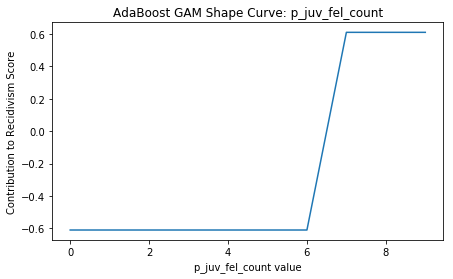

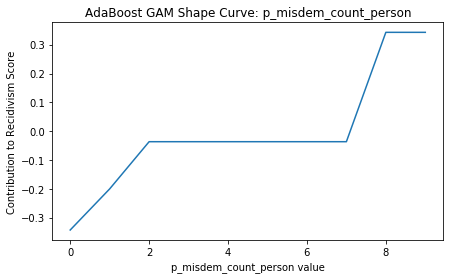

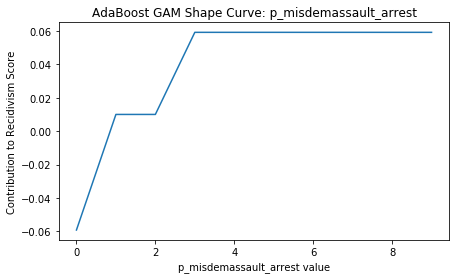

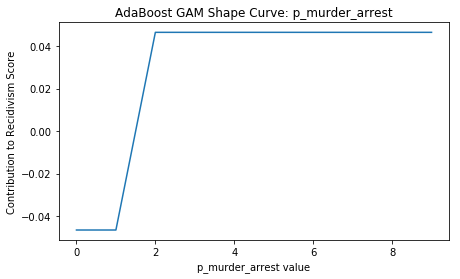

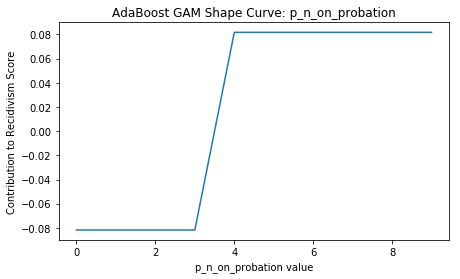

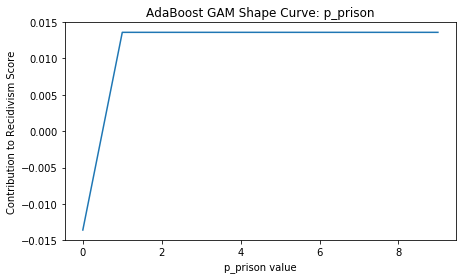

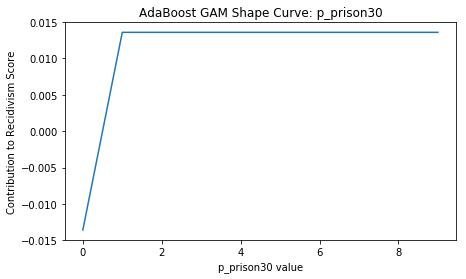

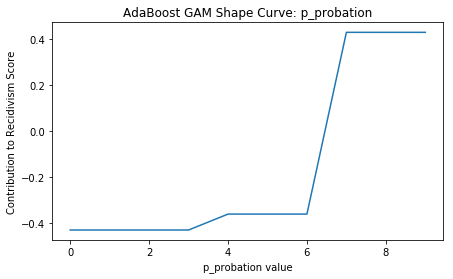

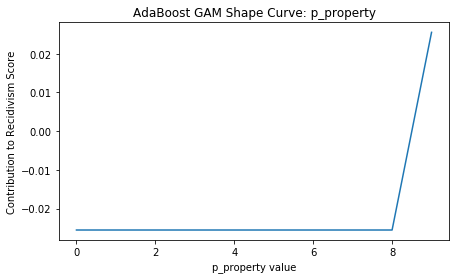

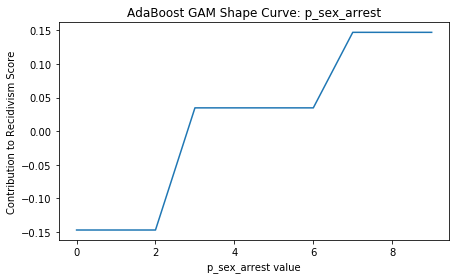

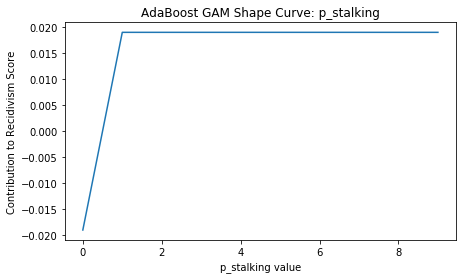

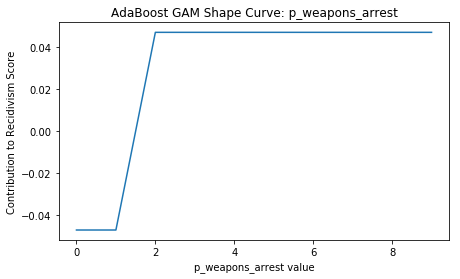

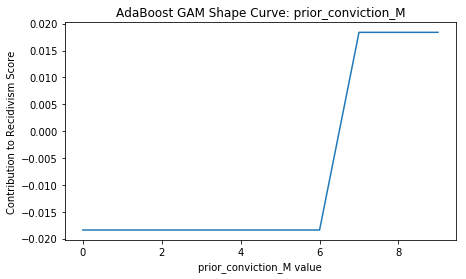

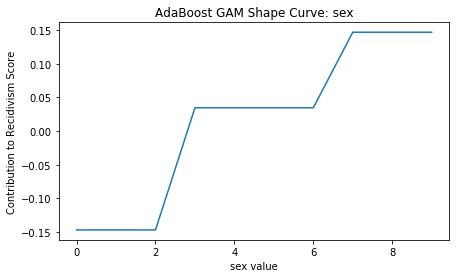

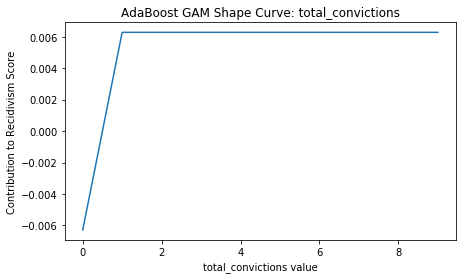

In [116]:
#get unique names for all features, without the numbers 
col_labels = np.array((train_pd.loc[:, train_pd.columns != 'recid_use']).columns.tolist())
unique_labels = np.unique(["_".join(label.split("_")[:-1]) for label in col_labels])

with PdfPages('adaboost_visualization.pdf') as pdf:
    for feature in unique_labels: 
        #get indices for all stumps corresponding to this feature 
        feat_inds = np.where(np.char.find(col_labels, feature)>=0)[0]

        #check if feature actually makes contribution to the score 
        contribution = False
        for feat_ind in feat_inds: 
            if feat_weights[feat_ind]!= 0: contribution = True 

        if contribution: 
            total_feats = X_train.shape[1] #total number of features 
            shape_plot(feature,  feat_inds,total_feats,feat_weights, col_labels, numwords2int)


In [108]:
numwords2int = {
    "one": 1, 
    "two": 2, 
    "three": 3, 
    "four": 4, 
    "five": 5,
    "six": 6, 
    "seven": 7, 
    "eight": 8, 
    "nine": 9, 
    "ten": 10, 
    "eleven": 11, 
    "twelve": 12, 
    #######
    "eighteen": 18, 
    "nineteen": 19, 
    "twenty": 20, 
    "twenty1": 21, 
    "twenty2": 22, 
    "twenty3": 23, 
    "twenty4": 24, 
    "twenty5": 25, 
    "twenty6": 26, 
    "twenty7": 27, 
    "twenty8": 28, 
    "twenty9": 29, 
    #######
    "thirty": 30, 
    "thirty1": 31, 
    "thirty2": 32, 
    "thirty3": 33, 
    "thirty4": 34, 
    "thirty5": 35, 
    "thirty6": 36, 
    "thirty7": 37, 
    "thirty8": 38, 
    "thirty9": 39, 
    #######
    "forty": 40, 
    "forty1": 41, 
    "forty2": 42, 
    "forty3": 43, 
    "forty4": 44, 
    "forty5": 45, 
    "forty6": 46, 
    "forty7": 47, 
    "forty8": 48, 
    "forty9": 49, 
    #######
    "fifty": 50, 
    "fifty1": 51, 
    "fifty2": 52, 
    "fifty3": 53, 
    "fifty4": 54, 
    "fifty5": 55, 
    "fifty6": 56, 
    "fifty7": 57, 
    "fifty8": 58, 
    "fifty9": 59, 
    ######
    "sixty": 60, 
    "sixty1": 61, 
    "sixty2": 62, 
    "sixty3": 63, 
    "sixt4": 64, 
    "sixty5": 65, 
}

%store numwords2int

Stored 'numwords2int' (dict)


In [22]:
#testing logistic regresesion 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, Y_train)
acc_lr = lr.score(X_test, Y_test)
print(acc_lr)

#testing random forest 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 5, bootstrap = True)
rf.fit(X_train, Y_train)
acc_rf = rf.score(X_test, Y_test)
print(acc_rf)

#test sklearn adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X_train, Y_train)
acc_bdt = bdt.score(X_test, Y_test)
print(acc_bdt)

0.5764075067024129
0.6327077747989276
0.6487935656836461
